# Creating a League of Legends Outcome Guessing System

In [3]:
import requests,json
import time
import re
import urllib
import calendar
import time
import traceback
import math
import sqlite3
import random
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pandas
from statistics import mean,stdev
from scipy.stats import norm
from bs4 import BeautifulSoup
from signal import signal, SIGINT
from sys import exit
from os import path

# Overview  
The following is a project from my Introduction to Data Science class in which we were expected to perform data curation, parsing, and management; exploratory data analysis; hypothesis testing and machine learning to provide analysis. Then finally I need to give a message talking about what I learned from my work.  
  
I initially intended to do this project in Rust, as a lot of my data curation work for another project was already written, but I changed course when I realized I needed to access [OP.GG](https://na.op.gg/) and manually scrape data. So to make things as painless as possible, I went with Python3, a language I'm very comfortable with.

# Context 
[League of Legends](https://na.leagueoflegends.com/en-us/) is a very popular [Multiplayer Online Battle Arena](https://en.wikipedia.org/wiki/Multiplayer_online_battle_arena) (MOBA) officially released in 2010, which has become the largest eSports game in the world, and boasts an impressive [80 million unique players every year](https://www.unrankedsmurfs.com/blog/players-2017). I have played League of Legends since the end of 2013 and continue to play almost every day, often playing with friends as a way to destress.  
  
There are several game modes, from a single lane team deathmatch with random champions, to a gamemode with low ability and item cooldowns to let players spam to their hearts' content, to the competitive ranked queue where players test themselves against one another.  
  
For this project I only ~~used~~ **INTENDED** to use data from both normal (non-competitive) and ranked gamemodes, **(As of 8:12PM on 5/18/20, I have just realized I was not filtering the matches correctly so I was accepting data from any format, and I have no time to fix it. ~~God damnit.~~. What this means is that we include modes where counter picking isn't an option as well as those without lane assignments, which messes with Hypothesis 4 later on.)** in a specific format known as draft, where there's more strategy involved and the potential to counter the enemy champion picks exists. If this is a bit confusing there's a lot of information for those who are new to the game [here](https://na.leagueoflegends.com/en-us/how-to-play/).  
  
There are many factors that go into winning a game of League of Legends, and working to classify them is important but often the onus lies on the choice of champions. Many professionals and high-level analysts will tell you that a game relies as heavily on, if not more on, the draft instead of the way the players execute the team composition they are given. There's a lot to it and if you're really curious there's a high ranked person who goes by LS and often does in depth dives into how a team wins draft, an example of how in-depth it can get can be found [here](https://www.youtube.com/watch?v=VDE5erfUEGI). (Warning, it's a 3 hour video about drafting a team and all the ins-and-outs of team compositions.)  
  
Given this information, it's not a far stretch to say we could guess which team has the advantage based on their draft alone. There are already examples of this (but this is a class project so I frankly don't care). An instance of this can be found [here](https://www.mobachampion.com/predict/) and a paper was even written about a very similar system to what I have planned [here](http://cs229.stanford.edu/proj2016/report/Lin-LeagueOfLegendsMatchOutcomePrediction-report.pdf). 

## What Constitutes Balance and How Can it Affect Predictions?
Balance is when often considered to be when a champion is sitting at exactly a 50 percent winrate, meaning that for every win that occurs on a champion, a loss will also occur. This ties into a champions perceived power level as seeing a very high winrate can indicate that a champion should be picked, but at the end of the day it is just a number, and is not a qualitative representation of a champions strength.  
  
If you're curious as to how Riot Games themselves classified champion balance, check out [this](https://nexus.leagueoflegends.com/en-us/2019/05/dev-champion-balance-framework/) dev blog from a year ago that goes pretty in-detail as to who their audience is and what they're trying to do with League of Legends.

# Data Curation
## Local File Reading
Below this we're building out mappings from champion numbers to names, Riot stores champions under numbers as they are universal and help to circumvent language barriers. These are all local files I have created through various other projects I have done using the Riot API.  
  
Next we take my self-classified damage types and insert them into a python dictionary. These classifications say whether a champion deals Physical Damage (AD), Magic Damage (AP), or they are not meant to do damage (NO). Additionally this classifies whether they are a Tank (TANK) or not.  
Finally we grab the champion winrates we harvested from OP.GG and build a dictionary mapping Champion name -> Winrate

In [4]:
# Build out the mapping of champion number to names
champion_map = {}
if not path.exists("resources/champ_mapping"):
    print("File doesn't exist: resources/champ_mapping")
    exit(0)
with open("resources/champ_mapping") as f:
    for line in f:
        vals = line.strip().split(":")
        champion_map[int(vals[0])] = vals[1]

In [5]:
# Map champions to the type of damage they deal (or indicate tank or No damage)
damage_map = {}
if not path.exists("resources/damage"):
    print("File doesn't exist: resources/damage")
    exit(0)
with open("resources/damage") as f:
    for line in f:
        vals = line.strip().split(":")
        damage_map[vals[0]] = vals[1]

In [6]:
# Map from the champions to each role and the winrate of each
champions_winrates = {}
with open("resources/winrates") as f:
    for line in f:
        vals = line.split(":")
        champions_winrates[vals[0]] = []
        for number in range(1,len(vals)):
            stuff = vals[number].strip().replace('(','').replace(')','').split(',')
            role = stuff[0]
            winrate = stuff[1].strip()
            champions_winrates[vals[0]].append((role,winrate))

## SQL Database Initialization
I chose [sqlite](https://www.sqlite.org/index.html) due to its compatability with Python, my familiarity with it, and the ability to store tables locally. If you want to create a new database and harvest new data for it, uncomment the first 4 lines and run the following block with an empty sql file. Otherwise just run the two blocks to make sure our lookup is seeded properly. It will create tables if none exist and then insert an accountId as a starting player to look through. This will not work if there are no draft games under your accountId.  
  
If you want to use your accountId instead, go to the [Riot Games API](https://developer.riotgames.com/apis#summoner-v4/GET_getBySummonerName), create an API Key for yourself and enter your summoner name. Then take the value that is returned under "accountId" and replace my accountId in the blocks below.

In [7]:
# Initialize database and return the connection to it
def initialize_database(cursor):
    #######################################################
    # UNCOMMENT THESE4  LINES IF STARTING A NEW DATA FILE #
    #######################################################
    #statement = "CREATE TABLE games (gameId INTEGER PRIMARY KEY,winner INTEGER,top1 varchar(25),jungle1 varchar(25),middle1 varchar(25),bottom1 varchar(25),support1 varchar(25),top2 varchar(25),jungle2 varchar(25),middle2 varchar(25),bottom2 varchar(25),support2 varchar(25));"
    #cursor.execute(statement)
    #statement = "CREATE TABLE summoners (accountId varchar(50), checked INTEGER);"
    #cursor.execute(statement)

    # Check if we've already seeded our table
    statement = "SELECT * FROM summoners WHERE accountId = 'W9U-Tzxs9WEMaovax0icYtLUlb9D7D0n0ZcL55TTZ-PV2-I';"
    f = cursor.execute(statement).fetchall()
    if len(f) == 0:
        # Fill in my personal account ID, replace with yours if you're intending to use yourself as a seed
        statement = "INSERT INTO summoners VALUES ('W9U-Tzxs9WEMaovax0icYtLUlb9D7D0n0ZcL55TTZ-PV2-I',0);"
        cursor.execute(statement)
        #print("inserting")
    return

In [8]:
sql = sqlite3.connect("/home/vmuser/final_project_320/database.db")
cursor = sql.cursor()

initialize_database(cursor)

## Winrate Updating from OP.GG
This function allows us to grab winrates from [OP.GG](https://na.op.gg/champion/statistics), a popular statistics aggregating website for the game, and replace the old ones. It's recommended you run this if you intend to test our code, as winrates can vary wildly from week-to-week. However this takes a long time, as there is a need to check every role for every champion (147 champions * 5 roles each = 735 Get Requests total). Alternatively you can work with the data I've already collected.  
  
To collect the data, I used [BeautifulSoup3](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) in tandem with the [Requests](https://requests.readthedocs.io/en/master/) and [Json](https://docs.python.org/3/library/json.html) modules provided with Python. The goal was to find the winning percentage for every champion in any given role they played. If there isn't enough data for a given role (determined by OP.GG) we simply indicate that in the file with a 'None'. These winrates are stored to data/winrates and will be used to calculate average winning percentage based on a teams choice of champions.  
  
The general workflow for this was get the page for each champion and each of the 5 roles (top, middle, jungle, support, bottom) and convert the page using BeautifulSoup to make it something we can search through. Then we search for a div element shared between each of the pages which contains the winrate. If we find one we strip it of it's percent sign and convert the remaining number to a float.

In [9]:
def update_wr():
    roles = ["top","jungle","mid","bot","support"]
    # Check if the file containing the names for all the champions exists or not. If not you'll get told off
    if not path.exists("resources/champcopy"):
        print("File doesn't exist: resources/champcopy")
        exit(0)
    # Now go through the champions, look up the winrate in every role and update our winrates file accordingly.
    with open("resources/champcopy") as f:
        with open("resources/winrates","w+") as writer:
            for champion in f:
                if champion != "":
                    champion = champion.strip()
                    # Request the page for each champion for each role
                    count = 0 # Keep track of how many roles we track for each champion
                    winrates = [] # Keep track of per role winrate
                    for role in roles:
                        element = "None"
                        url = 'https://na.op.gg/champion/{}/statistics/{}'.format(champion,role)
                        data = requests.get(url)
                        data = data.text
                        # Parse the html we get back and search for the element we want (winrate)
                        soup = BeautifulSoup(data,"html.parser")
                        if soup.find('div', attrs={'class': "champion-stats-trend-rate"}) != None:
                            element = soup.find('div', attrs={'class': "champion-stats-trend-rate"}).text.strip().replace("%","")
                            if element == "" or element == "%":
                                winrates.append((role,"None"))
                                continue
                            winrates.append((role,element))
                            print(element)
                            count += 1
                        else:
                            winrates.append((role,"None"))

                    writer.write("{}:".format(champion))
                    for (i,winrate) in enumerate(winrates):
                        writer.write("{}".format(winrate))
                        if i < len(winrates) - 1:
                            writer.write(":".format(winrate))
                    writer.write("\n")
    print("Finished updating winrate")
    return

### Driver for Updating From OP.GG
The code below asks if we should update or not, if you're short on time don't type yes.

In [119]:
#Update Winrate, only run if you have time.
in_val = input("Should I update winrates?\n")
if in_val == "y" or in_val == "yes":
    update_wr()
else:
    pass

Should I update winrates?n


## Riot Games API
The next portion is our data aggregator, which begins by asking the lower bound on the amount of games we should parse. Every summoner has 100 games parsed, and due to rate limits we occasionally set the program to sleep for 90 seconds to stop bumping into the limit. Due to this, this portion of the program takes a while. If testing, I recommend a lower bound of 500 games, which should go through 5-6 summoners. Additionally, this will take games starting from 5/13/20, as that's when the last balance patch was released. If you want to take more up to date games, change the starting date to the most recent patch date at 12:00. The patch dates can be found [here](https://www.pcgamesn.com/league-of-legends/lol-patch-cycle-2020), by looking for the most recent date (currently we are on patch 10.10, which was released on 5/13/20).  
  
A note, API Keys are not allowed in [public facing projects](https://developer.riotgames.com/docs/portal#web-apis_api-keys), so for this to work you will need your own, which is no problem as anyone with a Riot Account can sign up for a Development account.  
  
Now as for how this code works, we start by grabbing summoner account IDs from our table (which is pre-seeded by the blocks above), pick one and pull up their match history since the last patch which will give us the best indication of champion strength based on OP.GG data. We update that person's listing in our sql database (under the summoner table) to indicate we've parsed their match history, and then we go through each match.  
  
In each match we look for the two teams of champions, ignoring it if for some reason there are not 10 champions listed. We convert the numbers given to names using the champion_map dictionary and then insert that unique Game ID along with which team won, and the champions that were given into the Games sql data table. Next we add the other 9 players to our summoner table if they're not already there, giving us more matches to look through. Finally we commit to our database to make sure the changes went through.

In [93]:
# Pull data from the api and save it to our sql database
def data_aggregator(key,champion_map,conn,cursor):
    player_ids = []
    total_games = 0
    begin_time = calendar.timegm(time.strptime('May 13, 2020 @ 12:00:00 UTC', '%b %d, %Y @ %H:%M:%S UTC')) * 1000

    while True:
        in_val = input("What is the lower bound on the number of games you would like parsed?\n")

        if in_val.strip().isnumeric():
            in_val = int(in_val)
            break
        else:
            print("Non-numeric Answer, please provide an answer containing only numbers.")

    while True:
        # Grab summoners we haven't checked out yet
        statement = "SELECT accountId FROM summoners WHERE checked = 0;"
        ids = cursor.execute(statement).fetchall()

        for id in ids:
            player_ids.append(id[0])

        # Get the farthest back person
        name = player_ids.pop()
        print("Now on summoner: {}".format(name))

        # Update that we're checking out this players match history
        statement = "UPDATE summoners SET checked = 1 WHERE accountId = '{}';".format(name)
        cursor.execute(statement)
        conn.commit()

        # Hey dum-dum, you forgot to filter by queue type!!!
        # And now you have no time to fix it!!!
        # :)
        
        # Request someons list of matches and put it into a JSON body
        req = requests.get("""https://na1.api.riotgames.com/lol/match/v4/
            matchlists/by-account/{}?api_key={}&beginTime={}""".format(name,key,begin_time))
        summoner_games = req.json()

        # If something went wrong with our request, just ignore the game and move on
        if req.status_code != 200:
            if req.status_code == 403:
                print("Bad Key")
            else:
                print("Person doesn't exist!")
            player_ids.append(name)
            continue

        # Keep track of the number of games we've seen, just for now we're maxing at 1000
        if total_games > in_val:
            break

        # Go through the last games of a given summoner
        for (i,games) in enumerate(summoner_games["matches"]):
            # Keep track of the teams of champions
            team_1 = []
            team_2 = []

            # Limit of 100 games per player
            if i > 99:
                break

            # Progress indicator
            if total_games % 100 == 0:
                print("On game {}".format(total_games))

            # Write the match number
            match_number = games["gameId"]

            # Request the game info and put it into a json body
            request = requests.get("""https://na1.api.riotgames.com/lol/match/v4
                /matches/{}?api_key={}""".format(match_number,key))
            game = request.json()

            # If we have a bad status code we sleep for a minute to avoid the rate limit
            if request.status_code != 200:
                print("Hit my limit, on game {} going to sleep for a minute".format(total_games))
                time.sleep(90)
                continue

            # If for whatever reason there's no team field we just ignore it but mark
            # that we were there so we don't need to deal with it
            if "teams" not in game.keys():
                games_viewed.append(match_number)
                continue

            statement = "SELECT * FROM games WHERE gameId = {}".format(match_number)
            f = cursor.execute(statement).fetchmany(5)
            # We're see this game before so we don't want to do it again
            if len(f) != 0:
                continue

            # Check the wins here
            if game["teams"][0]["win"] == "Win":
                winner = 1
            else:
                winner = -1

            # Now get the champions and keep track of them
            for participant in game["participants"]:
                champion_name = champion_map[participant["championId"]]
                lane = participant["timeline"]["lane"].lower()
                if int(participant["teamId"]) == 100:
                    team_1.append(champion_name)
                else:
                    team_2.append(champion_name)

            # Add to the set of players we haven't seen yet
            for player in game["participantIdentities"]:
                id = player["player"]["currentAccountId"]
                statement = "SELECT * FROM summoners WHERE accountId = '{}';".format(id)
                output = cursor.execute(statement).fetchall()
                # If we don't have an entry for this summoner yet, we say "we'll get to you later"
                if len(output) == 0:
                    statement = "INSERT INTO summoners VALUES ('{}',0);".format(id)
                    cursor.execute(statement)

            total_games += 1

            if len(team_1) + len(team_2) == 10:
                statement = "INSERT INTO games VALUES ({},{},'{}','{}','{}','{}','{}','{}','{}','{}','{}','{}');".format(game["gameId"],winner,team_1[0],team_1[1],team_1[2],team_1[3],team_1[4],team_2[0],team_2[1],team_2[2],team_2[3],team_2[4])
                cursor.execute(statement)
            conn.commit()
        conn.commit()
    conn.commit()

    print("I looked over {} games total".format(total_games))
    return

### Driver to Aggregate Data and Assign Key
This code will assign our key value from the environment assigned elsewhere. Then it will check if we want to aggregate moe data or not.

In [26]:
key = %env key

In [9]:
in_val = input("Should I aggregate more data?\n")
if in_val == "y" or in_val == "yes":
    data_aggregator(key,champion_map,sql,cursor)
else:
    pass

Should I aggregate more data?
n


# Exploratory Data Analysis
## Winrate Distribution by Roles
I was curious about how the winrates would be spread over each role, but I ran into an issue where boxplots needed to have the same length, and we couldn't provide that with the current setup. Nevertheless I pressed on and was given a very odd graph. After looking at the data in this form I realized it would not be terribly useful for analysis due to the sheer amount of fake data I had to insert.  
  
Knowing this, I then chose to graph the distributions (without fake input values) using a histogram to really get a sense for how each role was distributed. This was done with all 5 roles, and the analysis will be above each code block. It should be mentioned that this data changes from week to week, so this is only as relevant as when it was posted. Additionally, the bottom lane winrate was most affected by my padding of our statistics, the box is there at 50 % but is extremely tiny. I expand a bit more on why that is in the Bottom Lane Distribution section.  
  
I classified outliers as those with less that 40 or higher than 60 percent winrates, as often times it's not uncommon to see a few champions go just beyond 45 or 55 percent based on player ability.

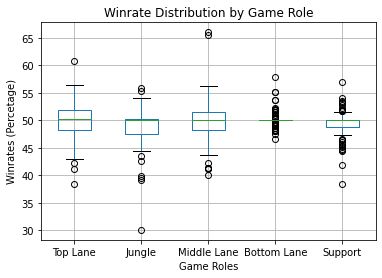

In [102]:
# Store the winrates for each role
top = []
mid = []
jungle = []
bot = []
support = []
with open("resources/winrates") as f:
    for line in f:
        if line != "":
            champ_and_roles = line.replace("'","").split(":")
            for stuff in champ_and_roles:
                split_up = stuff.replace("(","").replace(")","").split(',')
                if len(split_up) < 2:
                    continue
                role = split_up[0]
                wr = split_up[1].strip()
                # Grab the relevant winrate
                if wr != "None":
                    if role == "top":
                        top.append(float(wr.strip().replace("'","")))
                    elif role == "jungle":
                        jungle.append(float(wr.strip().replace("'","")))
                    elif role == "mid":
                        mid.append(float(wr.strip().replace("'","")))
                    elif role == "bot":
                        bot.append(float(wr.strip().replace("'","")))
                    elif role == "support":
                        support.append(float(wr.strip().replace("'","")))

# Get the max length of the lists
length = max(len(top),len(jungle),len(mid),len(bot),len(supp))

# Copy the lists to avoid issues down the line, make a dictionary to store the data for our boxplot
data = {'Top Lane':top.copy(),'Jungle':jungle.copy(),'Middle Lane':mid.copy(),
        'Bottom Lane':bot.copy(),'Support':support.copy()}

# Add in dummy values to satisfy the boxplot
for (key,value) in data.items():
    if len(value) < length:
        diff = length - len(value)
        value.extend([50.0] * diff)

# Shove it into a data frame and box plot it
frame = pandas.DataFrame(data)
boxplot = frame.boxplot()
plt.ylabel('Winrates (Percetage)')
plt.xlabel('Game Roles')
plt.title('Winrate Distribution by Game Role')
plt.show()

## Top Lane Distribution
Code to graph the distribution of top lane winrates.  
  
From the following graph, we can see that there is a relatively even spread, with a mean winrate of about 50%, indicating the amount of power and responsibility each of the champions can have.  
  
Let's talk about the outliers, at a winrate of 38.33% we have [Skarner](https://na.leagueoflegends.com/en-us/champions/skarner/), a very specialized champion meant to be played in the jungle where he can run around and gain control of certain zones of the map. If he is played in Top Lane he will not have the ability to take control of these zones as easily and will essentially be missing out on a powerful game mechanic that is unique to his character.  
  
The second outlier, sitting at a 60.76% winrate is [Karma](https://na.leagueoflegends.com/en-us/champions/karma/), a versatile but very simple mage who has many optimal build paths and very rarely gets beaten by a wide margin. Additionally the only people that tend to play this champion are those who play her a lot, meaning they are more likely to know how to win a given matchup.

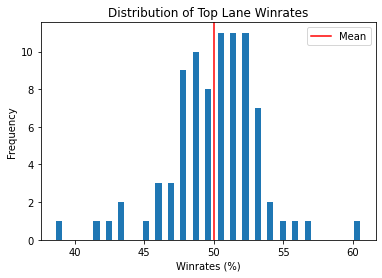

In [146]:
num_bins = 25 # Number of bins for histogram, 25 seemed pretty good and didn't overcrowd

# Put the data into a dataframe, graph the mean and the histogram of the dataframe
temp = pandas.DataFrame(top)
plt.axvline(x=temp[0].mean(),color="r")
plt.hist(top,num_bins,rwidth=0.5)
plt.title('Distribution of Top Lane Winrates')
plt.xlabel('Winrates (%)')
plt.ylabel('Frequency')
plt.legend(["Mean"])

plt.show()

## Jungle Distribution
Code to graph the distribution of jungle winrates.  
  
Jungle is a notoriously difficult role, often requiring a large amount of critical thinking, and those who don't play it often can find themselves being overwhelmed and defeated very quickly. At the same time, junglers can have a large impact on the game, and have been lowered in power many times to account for this, giving us a reasonable spread in winrates. This fits well with our graph, as most winrates are between 45 and 55 percent, which is considered to be pretty average. However, the mean winrate is about 48.5%, which reinforces the idea of a specialist role that is easy to make mistakes in.   
  
As for outliers here, we have [Kayle](https://na.leagueoflegends.com/en-us/champions/kayle/) at 39.83%, [Darius](https://na.leagueoflegends.com/en-us/champions/darius/) at 39.61%, [Talon](https://na.leagueoflegends.com/en-us/champions/talon/) at 39.26%, and [Zed](https://na.leagueoflegends.com/en-us/champions/zed/) at 30.1%. None of these champions were designed for the jungle, though recently ([Patch 10.4](https://na.leagueoflegends.com/en-us/news/game-updates/patch-10-4-notes/), Look for the "Jungle Champions" portion of the notes) Darius, Talon, and Zed were given buffs to help them play this role. This has led them to being played in that role, but it would appear that the people using this strategy are potentially not as well versed as they should be, or that it's just not a role the champion does well.  
  
Kayle is a special champion who relies on her in-game level to be strong, and jungling does not lend itself to that currently, as leveling is a very slow process if the champion has a weak early-game.

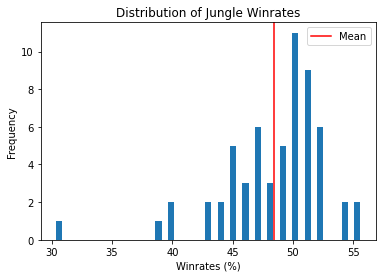

In [147]:
num_bins = 25 # Number of bins for histogram, 25 seemed pretty good and didn't overcrowd

# Put the data into a dataframe, graph the mean and the histogram of the dataframe
temp = pandas.DataFrame(jungle)
plt.axvline(x=temp[0].mean(),color="r")
plt.hist(jungle,num_bins,rwidth=0.5)
plt.title('Distribution of Jungle Winrates')
plt.xlabel('Winrates (%)')
plt.ylabel('Frequency')
plt.legend(["Mean"])

plt.show()

## Middle Lane DIstribution
Code to produce the distribution of Middle Lane winrates.  
  
In a similar vein to top lane, we see an almost normal distribution by the eye test. Champions in this role often have the ability to affect the rest of the map, as their position gives them access to both of the other lanes as well as the jungle. Interestingly we see over 20 champions sitting between 49.5 and 50% which indicates a relatively balanced set of champions. Additionally, we see a near 50% mean winrate, which would tend to indicate the champions in this role are well-balanced.  
  
The outliers in this case are [Kennen](https://na.leagueoflegends.com/en-us/champions/kennen/) and [Taric](https://na.leagueoflegends.com/en-us/champions/taric/). Kennen is unexpected, but I imagine his success is primarily due to his ultimate ability and it's game-changing potential.  
  
Taric is normally a support, but his winrate is extremely high due to a single strategy called [funneling](https://www.tiltreport.com/articles/697/what-funnel-strategy-league-legends-and-why-is-it-so-strong) in which he takes the Middle Lane position to give more money to the Jungler, who is normally meant to become strong much later into the game, and help to make them much stronger much sooner. It's not very common anymore due to multiple rounds of nerfs (power decreases), but it is still an effective strategy as evidenced by its winrate.

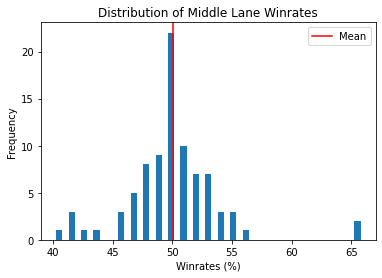

In [148]:
num_bins = 25 # Number of bins for histogram, 25 seemed pretty good and didn't overcrowd

# Put the data into a dataframe, graph the mean and the histogram of the dataframe
temp = pandas.DataFrame(mid)
plt.axvline(x=temp[0].mean(),color="r")
plt.hist(mid,num_bins,rwidth=0.5)
plt.title('Distribution of Middle Lane Winrates')
plt.xlabel('Winrates (%)')
plt.ylabel('Frequency')
plt.legend(["Mean"])

plt.show()

## Bottom Lane Distribution
Code to plot the distribution of Bottom Lane winrates.  
  
Bottom Lane is a very specialized role, often consisting of a ranged high-damage champion who relies on a supportive champion to help them in their lane. Generally this lane is kept under a close eye as the ability for this lane to take over the game is disproportionate to others due to them having a support to help keep them alive and allow them to make plays. Though it should be noted that many of these champions are expected to receive buffs soon to help them become more relevant in the game. The mean is about 51%, which tells me the role is pretty well balanced at the moment, possibly leaning towards being slightly strong.  
  
There weren't any real outliers in this role, again mostly due to the closely-watched nature of it, in addition to the high game-knowledge and game-mechanic requirements.  

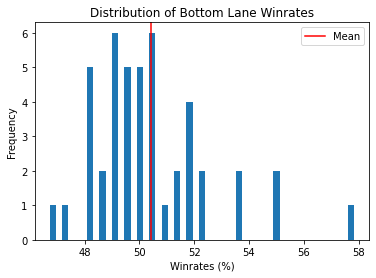

In [150]:
num_bins = 25 # Number of bins for histogram, 25 seemed pretty good and didn't overcrowd

# Put the data into a dataframe, graph the mean and the histogram of the dataframe
temp = pandas.DataFrame(bot)
plt.axvline(x=temp[0].mean(),color="r")
plt.hist(bot,num_bins,rwidth=0.5)
plt.title('Distribution of Bottom Lane Winrates')
plt.xlabel('Winrates (%)')
plt.ylabel('Frequency')
plt.legend(["Mean"])

plt.show()

## Support Distribution
Code to graph the distribution of support winrates.  
  
Supports have the job of helping their team, which can happen in various ways, be it keeping their bottom laner alive or setting up playes for their team. This puts a lot of power into the support role to affect the game, but also puts a lot of pressure on the role as well. We can see that supports tend to spread pretty evenly between 45 and 53 percent, which tells me that most supports tend to be pretty balanced in fulfilling what their role and their champion is meant to do. Additionally, our mean value is lying at the 49 percent mark, which may indicate an underpowered role, or that it's a difficult role to find success with.  
  
Our single outlier is [Nunu &amp; Willump](https://na.leagueoflegends.com/en-us/champions/nunu/) who's kit does not lend itself well to the role when compared with other champions. 

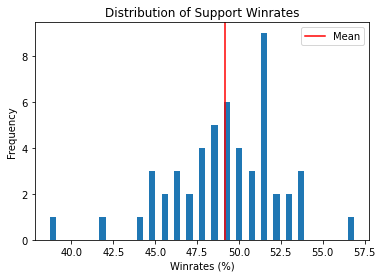

In [149]:
num_bins = 25 # Number of bins for histogram, 25 seemed pretty good and didn't overcrowd

# Put the data into a dataframe, graph the mean and the histogram of the dataframe
temp = pandas.DataFrame(support)
plt.axvline(x=temp[0].mean(),color="r")
plt.hist(support,num_bins,rwidth=0.5)
plt.title('Distribution of Support Winrates')
plt.xlabel('Winrates (%)')
plt.ylabel('Frequency')
plt.legend(["Mean"])

plt.show()

# Hypothesis Testing and Analysis
My 4 Hypotheses were:  
1. Given the average winrate of the champions on each team, we can guess the outcome of any given match.  
2. Given a team composition, we can use the spread of damage and the amount of tanks to guess the outcome of any given match.  
3. Given both a the average winrate of a team and the spread of damage, we can guess the outcome of any given match.
4. Given the average winrate of the champions on each team for the role they play, or the combined average of all roles they play, we can guess the outcome of any given match.

## Hypothesis 1: Guess From Winrates Only
This is a function to guess the outcome of a game given only the winrates. If you want updates, you can uncomment the print lines at the bottom, but when I call this function later, I have it graph this later, so it's not really necessary. First it calculates the average winrate across both teams, using the average winrate per champion across all roles they are played in, then takes the higher value and assigns a winner based off that.

In [33]:
def guess_only_winrates(winrate_map,champion_map,damage_types,conn,cursor,values):    
    # Keep track of times correct and the total number of guessed
    correct = 0
    total = 0

    # Now we begin guessing
    for (gameId,winner,top1,jungle1,middle1,bottom1,support1,top2,jungle2,middle2,bottom2,support2) in values:
        # Build out our lists of teams
        team_1 = [top1,jungle1,middle1,bottom1,support1]
        team_2 = [top2,jungle2,middle2,bottom2,support2]

        # Calculate our winrate averages for each team of champions
        (wr1,wr2) = calculate_average_wr(winrate_map,team_1,team_2)

        # If team_1 would win we say +1, otherwise -1
        if wr1 > wr2:
            guessed_winner = 1
        else:
            guessed_winner = -1

        # Check against the known outcome
        if winner == guessed_winner:
            correct += 1
            
        total += 1

        #print("""On this pass we ended up with {} correct 
            #out of {} for a correct percentage of {}""".format(correct,total,100.0 * correct/total))

    return (correct,total)

### Calculating Average Winrate
Here we are just calculating the average winrate across both teams and returning them

In [32]:
def calculate_average_wr(winrate_map,team_1,team_2):
    team_1_total = 0
    team_2_total = 0
    
    # Add the winrates up and divide by 5 (5 champions per team)
    for champion in team_1:
        used_winrate = 0.0
        count = 0
        # Make sure we're only grabbing winrates that exist
        for (position,winrate) in winrate_map[champion]:
            if winrate != "'None'":
                # Remove extraneous characters that end up on the file for whatever reason
                used_winrate = used_winrate + float(winrate.replace("'",""))
                count += 1
        used_winrate = used_winrate / count
        team_1_total += used_winrate

    for champion in team_2:
        used_winrate = 0.0
        count = 0
        # Make sure we're only grabbing winrates that exist
        for (position,winrate) in winrate_map[champion]:
            if winrate != "'None'":
                # Remove extraneous characters that end up on the file for whatever reason
                used_winrate = used_winrate + float(winrate.replace("'",""))
                count += 1
        used_winrate = used_winrate / count
        team_2_total += used_winrate

    return (team_1_total/5,team_2_total/5)

### Winrate Only Driver
To test this, I took varying amounts of games from our sample data and simply averaged both winrates, giving the predicted win to the higher of the two. We ran this 1000 times, each on a different sample of each size.  

In [112]:
times = 0

# Buckets of sample sizes
output_graph_winrate = {1000:[],2000:[],3000:[],4000:[],5000:[],6000:[],7000:[],8000:[]}

# Repeat this process 100 times
while times < 100:
    # Select v games from our sample data
    for v in output_graph_winrate.keys():
        statement = "SELECT * FROM games ORDER BY random() LIMIT %d" %(v,)
        output = cursor.execute(statement)        
        values = output.fetchall()

        (correct,total) = guess_only_winrates(champions_winrates,champion_map,damage_map,sql,cursor,values)
        
        output_graph_winrate[v].append(100.0 * correct/total)

    times += 1

### Distribution of Correct Guesses Based only on Winrate
Code to graph the outcome of only guessing based on winrate.  
  
The graph of this is very interesting, we can see that at a low sample amount, the variance was large, with a range of over 7%, but as we pulled more data into each sample set  that variance gradually closed. This holds to the adage that more data is likely to give you more accurate results. Additionally, we can see that we eventually come very close to 51%, though I believe this is due to the size of the data I have available.

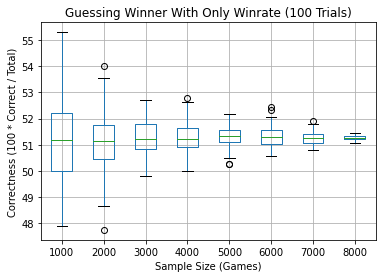

In [116]:
frame = pandas.DataFrame(output_graph_winrate)
boxplot = frame.boxplot()

plt.ylabel('Correctness (100 * Correct / Total)')
plt.xlabel('Sample Size (Games)')
plt.title('Guessing Winner With Only Winrate (100 Trials)')
plt.show()

## Hypothesis 2: Guess From Damage Spread Only
The following block of code will produce a guess as to which team will win solely based off of the spread of damage and the amount of tanks on two given teams. For every tank we will assign one point in favor of that team. Then if any team is missing a given type of damage, we assign a point to the enemy team (as it gives them an advantage). Then at the end we check where the value stands, positive indicates team_1 wins, negative indicates team_2 wins.

In [34]:
def guess_only_ad_ap(winrate_map,champion_map,damage_types,conn,cursor,values):
    # Keep track of times correct and the total number of guessed
    total = 0
    correct = 0
    ad_ap_value = 0
    
    # Now we begin guessing
    for (gameId,winner,top1,jungle1,middle1,bottom1,support1,top2,jungle2,middle2,bottom2,support2) in values:
        # Build out our lists of teams
        team_1 = [top1,jungle1,middle1,bottom1,support1]
        team_2 = [top2,jungle2,middle2,bottom2,support2]

        # Calculate amount of ADs, APs, and Tanks on each team
        (ad1,ap1,tank1) = calculate_ad_ap(team_1,damage_types)
        (ad2,ap2,tank2) = calculate_ad_ap(team_2,damage_types)

        # Tanks give that team some advantage
        for i in range(0,tank1):
            ad_ap_value += 1
        for i in range(0,tank2):
            ad_ap_value -= 1

        # We give large value to the other team if the damage spread isn't great
        if ad1 == 0 or ap1 == 0:
            ad_ap_value -= 2
        if ad2 == 0 or ap2 == 0:
            ad_ap_value += 2 
            

        # If our value is > 0, team_1 should win, otherwise it's team_2
        if ad_ap_value > 0:
            guessed_winner = 1
        else:
            guessed_winner = -1

        if winner == guessed_winner:
            correct += 1
            
        total += 1

        #print("On this pass we ended up with {} correct out of {} for a correct percentage of {}".format(correct,total,100.0 * correct/total))

    return (correct,total)

### Calulcate Damage Spread
Below we're just calculating the number of each type of damage and the amount of tanks.

In [35]:
def calculate_ad_ap(team,damage_map):
    num_ad = 0
    num_ap = 0
    num_tanks = 0
    # No switch statements in python so we make do with what we have
    for champion in team:
        if damage_map[champion] == "AP":
            num_ap += 1
        elif damage_map[champion] == "AD":
            num_ad += 1
        elif damage_map[champion] == "TANK":
            num_tanks += 1
    return (num_ad,num_ap,num_tanks)

### Driver for Damage Spread and Tank Count Only
When it came time to test my second hypothesis things became a bit trickier. I employed the same idea of selecting a random subset of the data and testing against that. This time I was counting the number of ADs, APs and Tanks, and adding or subtracting from a single value to produce one that was positive or negative. If it was 0 it was impossible to know and it would be a coinflip based on the current criteria.

In [155]:
# Keep track of number of trials
times = 0

# Buckets of sample sizes
output_graph_ad_ap = {1000:[],2000:[],3000:[],4000:[],5000:[],6000:[],7000:[],8000:[]}

# Repeat this process 100 times
while times < 100:
    for v in output_graph_ad_ap.keys():
        statement = "SELECT * FROM games ORDER BY random() LIMIT %d" %(v,)
        output = cursor.execute(statement)        
        values = output.fetchall()

        (correct,total) = guess_only_ad_ap(champions_winrates,champion_map,damage_map,sql,cursor,values)
        
        output_graph_ad_ap[v].append(100.0 * correct/total)

    times += 1

### Distribution of Correct Guesses Based Only on Damage Spread and Tank Count
Code to graph the output of our guessing based only on damage type and spread.    
  
Here we actually see a very similar outcome to guessing solely based on winrates. The skew is greater for the 1000 sample size event, but beyond that they are extremely similar. When looking at this I actually had to put them side by side to make sure I hadn't just graphed the same thing twice. Interestingly, even at high sample values, we still ended up with around 51% correctness on average, though we did have outliers that dipped slightly below 50%.

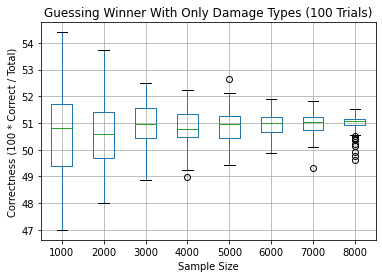

In [157]:
frame = pandas.DataFrame(output_graph_ad_ap)
boxplot = frame.boxplot()

plt.ylabel('Correctness (100 * Correct / Total)')
plt.xlabel('Sample Size')
plt.title('Guessing Winner With Only Damage Types (100 Trials)')
plt.show()

## Hypothesis 3: Combining Damage Spread and Average Winrate
Here I decided to use [Gradient Descent](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html) to find a good way to combine our two previous methods to produce a better version. The four blocks below help me calculate new weights for each component.  
  
The first one computes the weighted total of all our inputs (winrate and damage spread). Then we calculate the sigma for this, which make calculations for updating weights a bit easier. As for updating weights we use the expected value (who won), sigma (we just calculated), x values (the inputs), the learning rate (sometimes denoted as alpha) and the weight initial. The last one calculates Loss and tells us how far from each data point we are. I intended to use it to check if we were close enough but I don't think it was working properly in my setup, so I scrapped it and didn't end up using it.

In [38]:
def calculate_z(weight_and_values):
    z = 0
    for (weight,value) in weight_and_values:
        z += weight * value
    return z

In [39]:
def calculate_sigma(z):
    sigma = 1/(1 + math.exp(-z))
    return sigma

In [40]:
# y is the expected value array
# sigma is sigma(z(x)) ~= o_j
# x is the actual calculated value array 
# Learning Rate is alpha
def update_weights(y, sigma_values, x, learning_rate, weight_initial):
    summation = 0
    # Complicated Gradient Descent function calculation
    for (j,o_j) in enumerate(sigma_values):
        summation += (y[j] - o_j) * o_j * (1 - o_j) * x[j]
    d_e = -summation
    weight_new = weight_initial - learning_rate * d_e
    return weight_new

In [41]:
def calculate_loss(y,sigma):
    return 0.5 * ((y - sigma) ** 2)

### Training 
My initial idea was to use Gradient Descent to learn the best weights for both winrate and damage spread and tank count to help improve my guesses. This didn't work well, so what I instead tried to do was learn the best weight as I went. My learning rate stayed small as I thought I would be doing enough trials to have it make a difference, but apparently not.  
  
The idea behind the code is to calculate both the winrate and the damage spread as seen in Hypotheses 1 and 2 and then calculate sigma(z(x)) and use that to update our weights.

In [44]:
def guess_with_training(winrate_map,champion_map,damage_types,conn,cursor,values,winrate_weight,ad_ap_weight,learning_rate):
    times = 0

    guessed_rates = 0.0

    correct = 0
    total = 0
    
    x_values_wr = [] # This is x_j for winrates
    x_values_ad_ap = [] # This is x_j for ad_ap
    sigma_wr_calculated = [] # This is sigma(z(x)) for winrates
    sigma_ad_ap_calculated = [] # This is sigma(z(x)) for ad_ap
    winners = [] # This is essentially y
    
    # Now we begin guessing
    for (i,(gameId,winner,top1,jungle1,middle1,
            bottom1,support1,top2,jungle2,middle2,bottom2,support2)) in enumerate(values):
        # Build out our lists of teams
        team_1 = [top1,jungle1,middle1,bottom1,support1]
        team_2 = [top2,jungle2,middle2,bottom2,support2]

        winners.append(winner)

        ad_ap_value = 0

        # Calculate the average winrates for the two teams
        (wr1,wr2) = calculate_average_wr(winrate_map,team_1,team_2)

        # Winner by winrate
        winrate = wr1-wr2

        x_values_wr.append(winrate)

        # Calculate the damage spread and tankiness of the teams
        (ad1,ap1,tank1) = calculate_ad_ap(team_1,damage_types)
        (ad2,ap2,tank2) = calculate_ad_ap(team_2,damage_types)

        # Calculate the value from damage spread
        # Tanks give that team some advantage
        for i in range(0,tank1):
            ad_ap_value += 1
        for i in range(0,tank2):
            ad_ap_value -= 1

        # We give large value to the other team if the damage spread isn't great
        if ad1 == 0 or ap1 == 0:
            ad_ap_value -= 2
        if ad2 == 0 or ap2 == 0:
            ad_ap_value += 2 

        x_values_ad_ap.append(ad_ap_value)

        # Used to calculate z(x)
        weight_and_values = [(winrate,winrate_weight),(ad_ap_value,ad_ap_weight)]

        z_x_wr = calculate_z([(winrate,winrate_weight)])

        z_x_ad_ap = calculate_z([(ad_ap_value,ad_ap_weight)])

        sigma_z_x_wr = calculate_sigma(z_x_wr)

        sigma_z_x_ad_ap = calculate_sigma(z_x_ad_ap)

        sigma_wr_calculated.append(sigma_z_x_wr)

        sigma_ad_ap_calculated.append(sigma_z_x_ad_ap)

        guessed_val = calculate_z(weight_and_values)

        if guessed_val > 0:
            guessed_winner = 1
        else:
            guessed_winner = -1    

        if winner == guessed_winner:
            correct += 1
        total += 1

        e_w = calculate_loss(winner,guessed_val)

    # Possible these should be moved into the for loop, ignored if loss is low enough?
    winrate_weight = update_weights(winners, sigma_wr_calculated, x_values_wr, learning_rate, winrate_weight)

    ad_ap_weight = update_weights(winners, sigma_ad_ap_calculated, x_values_ad_ap, learning_rate, ad_ap_weight)

    #learning_rate = learning_rate / 2

    #print("On pass {}: Our current weights are:\nwinrate: {}\nad_ap: {}".format(times,winrate_weight,ad_ap_weight))
    #print("On this pass we ended up with {} correct out of {} for a correct percentage of {}".format(correct,total,100.0 * correct/total))
    #print("%d Correct\n%d Total\n%.1f Percent correct\nThe optimal weights were: %.4f and %.4f" %(correct, total,100.0 * correct / total,winrate_weight,ad_ap_weight))

    times += 1
    guessed_rates += correct / total
        
    return (correct,total,winrate_weight,ad_ap_weight,learning_rate)

### Driver for Gradient Descent
Code to test our gradient descent using various sample sizes. Grabs some amount of random samples and tries to find a weight that works.

In [45]:
# Keep track of number of trials
times = 0

output_graph_trained = {1000:[],2000:[],3000:[],4000:[],5000:[],6000:[],7000:[],8000:[]}

winrate_weight = 0.5
ad_ap_weight = 0.5
learning_rate = 0.001

while times < 100:
    for v in output_graph_trained.keys():
        statement = "SELECT * FROM games ORDER BY random() LIMIT %d" %(v,)
        output = cursor.execute(statement)        
        values = output.fetchall()
        (correct,total,winrate_weight,ad_ap_weight,learning_rate) = guess_with_training(champions_winrates,champion_map,damage_map,sql,cursor,values,winrate_weight,ad_ap_weight,learning_rate)
        #print("%d %d %.2f" %(correct,total, 100.0 * correct / total))
        #print("%.2f %.2f" %(wr_weight,ad_ap_weight))
        output_graph_trained[v].append(100.0 * correct/total)
        #print(v)
        
    times += 1

### Graphing Gradient Descent Output
I was hoping to see something slightly more promising, but unfortunately it appears that this method proves about as effective as winrates only and damage spread onyl, boasting only a 51% correctness on average at high sample values. The spread was worse than that of winrates only as well.

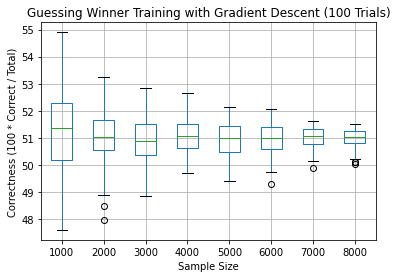

In [46]:
frame = pandas.DataFrame(output_graph_trained)
boxplot = frame.boxplot()

plt.ylabel('Correctness (100 * Correct / Total)')
plt.xlabel('Sample Size')
plt.title('Guessing Winner Training with Gradient Descent (100 Trials)')
plt.show()

## Hypothesis 4: Guessing Based on Winrate and Lane Selection
My gradient descent attempt didn't produce a better outcome than before, I'm not sure if it's due to the values I assigned to it, or if the learning rate was off, but I didn't have the time to figure that out so I decided to try something different. The Riot API will occasionally contain a "Lane" value for each participant telling us the lane they played. Unfortunately this is seemingly random and isn't reliable, however I think it's good enough to see some improvement. The code below helps test this.  
  
Unfortunately, since I did not store the full game data from the API, I have to call the API again on the gameId to get the lane information. This is a slow and arduous process and I would only do so if you have nothing better to do. Alternatively if you want to see just one pass, you can change the code in the second block to go from range 0 to 1.  
  
So as for what the code is doing, we're calling the API, pulling up the match details, looking for the participants lane, then looking for the champion they were playing while in that lane, search up the winrate and use that instead of the average. If no lane was recorded, for whatever reason, we just use the average of each role as we did without lane information. 

In [67]:
def try_for_lanes(champion_map,winrate_map,key,cursor,amount):
    # Grab 2000 games at random from our sql database
    statement = "SELECT * FROM games ORDER BY random() LIMIT {}".format(amount)
    output = cursor.execute(statement).fetchall()
    correct = 0

    total = 0

    for (gameId,winner,top1,jungle1,middle1,bottom1,support1,top2,jungle2,middle2,bottom2,support2) in output:
        total_1 = 0
        total_2 = 0
        times_repeated = 0
        while True:
            request = requests.get("https://na1.api.riotgames.com/lol/match/v4/matches/{}?api_key={}".format(gameId,key))
            if request.status_code != 200:
                #print("Sleeping for 2 minutes")
                time.sleep(90)
            else:
                break
        game = request.json()
        #print(len(game["participants"]))
        if "participants" not in game.keys():
            continue
        # Now get the champions and keep track of them
        for participant in game["participants"]:
            used_winrate = 0
            count = 0
            champion_name = champion_map[participant["championId"]]
            lane = participant["timeline"]["lane"].lower()
            # If the player was top lane
            if lane == "TOP":
                (position,winrate) = winrate_map[champion_name]["'top'"]
                if winrate != "'None'":
                    # Remove extraneous characters that end up on the file for whatever reason
                    wr = float(winrate.replace("'",""))
                # Otherwise we need to do an average of all the winrates
                else:
                    # Make sure we're only grabbing winrates that exist
                    for (position,winrate) in winrate_map[champion_name]:
                        if winrate != "'None'":
                            # Remove extraneous characters that end up on the file for whatever reason
                            used_winrate += used_winrate + float(winrate.replace("'",""))
                            count += 1
                    wr = used_winrate / count
                if int(participant["teamId"]) == 100:
                    total_1 += wr
                else:
                    total_2 += wr
            elif lane == "JUNGLE":
                (position,winrate) = winrate_map[champion_name]["'jungle'"]
                if winrate != "'None'":
                    # Remove extraneous characters that end up on the file for whatever reason
                    wr = float(winrate.replace("'",""))
                # Otherwise we need to do an average of all the winrates
                else:
                    # Make sure we're only grabbing winrates that exist
                    for (position,winrate) in winrate_map[champion_name]:
                        if winrate != "'None'":
                            # Remove extraneous characters that end up on the file for whatever reason
                            used_winrate = used_winrate + float(winrate.replace("'",""))
                            count += 1
                    wr = used_winrate / count
                if int(participant["teamId"]) == 100:
                    total_1 += wr
                else:
                    total_2 += wr
            elif lane == "MIDDLE":
                (position,winrate) = winrate_map[champion_name]["'mid'"]
                if winrate != "'None'":
                    # Remove extraneous characters that end up on the file for whatever reason
                    wr = float(winrate.replace("'",""))
                # Otherwise we need to do an average of all the winrates
                else:
                    # Make sure we're only grabbing winrates that exist
                    for (position,winrate) in winrate_map[champion_name]:
                        if winrate != "'None'":
                            # Remove extraneous characters that end up on the file for whatever reason
                            used_winrate = used_winrate + float(winrate.replace("'",""))
                            count += 1
                    wr = used_winrate / count
                if int(participant["teamId"]) == 100:
                    total_1 += wr
                else:
                    total_2 += wr
            elif lane == "BOTTOM":
                (position,winrate) = winrate_map[champion_name]["'bot'"]
                if winrate != "'None'":
                    # Remove extraneous characters that end up on the file for whatever reason
                    wr = float(winrate.replace("'",""))
                # Otherwise we need to do an average of all the winrates
                else:
                    # Make sure we're only grabbing winrates that exist
                    for (position,winrate) in winrate_map[champion_name]:
                        if winrate != "'None'":
                            # Remove extraneous characters that end up on the file for whatever reason
                            used_winrate = used_winrate + float(winrate.replace("'",""))
                            count += 1
                    wr = used_winrate / count
                if int(participant["teamId"]) == 100:
                    total_1 += wr
                else:
                    total_2 += wr
            elif lane == "SUPPORT":
                (position,winrate) = winrate_map[champion_name]["'support'"]
                if winrate != "'None'":
                    # Remove extraneous characters that end up on the file for whatever reason
                    wr = float(winrate.replace("'",""))
                # Otherwise we need to do an average of all the winrates
                else:
                    # Make sure we're only grabbing winrates that exist
                    for (position,winrate) in winrate_map[champion_name]:
                        if winrate != "'None'":
                            # Remove extraneous characters that end up on the file for whatever reason
                            used_winrate = used_winrate + float(winrate.replace("'",""))
                            count += 1
                    wr = used_winrate / count
                if int(participant["teamId"]) == 100:
                    total_1 += wr
                else:
                    total_2 += wr
            else:
                # Make sure we're only grabbing winrates that exist
                for (position,winrate) in winrate_map[champion_name]:
                    if winrate != "'None'":
                        # Remove extraneous characters that end up on the file for whatever reason
                        used_winrate = used_winrate + float(winrate.replace("'",""))
                        count += 1
                wr = used_winrate / count
                if int(participant["teamId"]) == 100:
                    total_1 += wr
                else:
                    total_2 += wr
            #print(total_1)
            #print(total_2)
        #print(gameId)
        if total_1 > total_2:
            guessed = 1
        else:
            guessed = -1
        if guessed == winner:
            correct += 1
        total += 1

    #print("%d %d %.2f" %(correct,total,100 * correct/total))
    return (correct,total)

### Driver Code for Distribution with Potentially Known Winrate
Code to attempt to guess with lane information potentially known.

In [79]:
amount = {50: []}
my_key = %env key
my_key = my_key.replace('"','')
for i in range(0,30):
    for am in amount.keys():
        (correct,total) = try_for_lanes(champion_map,champions_winrates,my_key,cursor,am)
        amount[am].append(100.0 * correct / total)

### Distribution of Winrate Knowing Lanes
Code to show the distributions of correct guessed based off of Winrates and knowing the lanes. I wasn't able to run this more due to time constraints.  
  
What we can see from it, however, is that there is a measurable increase in guessing correctly, sitting at about 52.5% instead of the prior 51%. This is on a somewhat small sample size however, and would need more testing to be done on it. Additionally, this data includes games that don't have positional data attached to them, if they did I believe we would see a significant increase in guessing capability, to upwards of 60 percent.

81


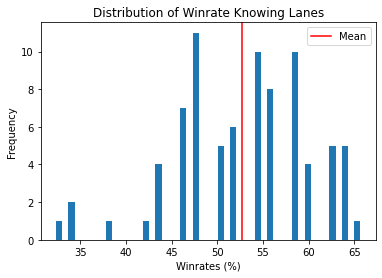

In [81]:
num_bins = 25 # Number of bins for histogram, 25 seemed pretty good and didn't overcrowd
print(len(amount[50]))
temp = pandas.DataFrame(amount[50])
plt.axvline(x=temp[0].mean(),color="r")
plt.hist(amount[50],num_bins,rwidth=0.5)
plt.title('Distribution of Winrate With Potential Known Lanes (81 Games)')
plt.xlabel('Winrates (%)')
plt.ylabel('Frequency')
plt.legend(["Mean"])

plt.show()

# Conclusion
Overall this experiment showed the viability of a guessing system, occasionally being slightly better than a coinflip and having some stand out performances under certain data conditions (having lane assignments be known for instance), leaving a lot of room for growth and expansion. We could clearly see that adding new parameters to a guessing system didn't always produce positive results (Hypothesis 3), but properly using those which directly contribute to the selection of a certain metric to use, should result in a positive increase in guessing capabilities (Hypothesis 4)  
  
Another area to look at to improve upon would be the API Key available to me, this key does not allow for a lot of requests, capping at 100 per 2 minutes, leading to significant bottlenecking when collecting data and parsing from the API. The only way to do this would have been to get a production api key, which is an arduous process requiring me to have a working prototype and would expect me to be dealing with the general public.  
  
In a similar vein, I think with more time, there would be a high likelihood for developing a system that correctly guesses games with upwards of 60% correctness. Overall I enjoyed this project despite the setbacks and current implementation restrictions, and it's very possible I expand this into a full-blown personal project.